# Train vs. Test dataset distributions

https://www.kaggle.com/nanomathias/distribution-of-test-vs-training-data/code

Before getting started on this competition I quickly wanted to check the distributions of the test dataset against that of the training dataset, and if possible see how different from each other they are.

In [2]:
import gc
import itertools
from copy import deepcopy

import numpy as np
import pandas as pd

from tqdm import tqdm

from scipy.stats import ks_2samp

from sklearn.preprocessing import scale, MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn import manifold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
%matplotlib inline

# 1. t-SNE Distribution Overview
To start out I'll take out an equal amount of samples from the train and test dataset (4459 samples from both, i.e. entire training set and sample of test set), and perform a t-SNE on the combined data. I'm scaling all the data with mean-variance, but for columns where we have outliers (> 3x standard deviation) I also do a log-transform prior to scaling.

## 1.0. Data Pre-Processing
Current pre-processing procedure:
* Get 4459 rows from training set and test set and concatenate them
* Columns with standard deviation of 0 in training set removed
* Columns which are duplicate in training set removed
* Log-transform all columns which have significant outliers (> 3x standard deviation)
* Create datasets with: 
    * Mean-variance scale all columns including 0-values!
    * Mean-variance scale all columns **excluding** 0-values!
    

In [3]:
%%time 

# How many samples to take from both train and test
SAMPLE_SIZE = 4459

# Read train and test files
train_df = pd.read_csv('../input/train.csv').sample(SAMPLE_SIZE)
test_df = pd.read_csv('../input/test.csv').sample(SAMPLE_SIZE)

# Get the combined data
total_df = pd.concat([train_df.drop('target', axis=1), test_df], axis=0).drop('ID', axis=1)

# Columns to drop because there is no variation in training set
zero_std_cols = train_df.drop("ID", axis=1).columns[train_df.std() == 0]
total_df.drop(zero_std_cols, axis=1, inplace=True)
print(f">> Removed {len(zero_std_cols)} constant columns")

# Removing duplicate columns
# Taken from: https://www.kaggle.com/scirpus/santander-poor-mans-tsne
colsToRemove = []
colsScaned = []
dupList = {}
columns = total_df.columns
for i in range(len(columns)-1):
    v = train_df[columns[i]].values
    dupCols = []
    for j in range(i+1,len(columns)):
        if np.array_equal(v, train_df[columns[j]].values):
            colsToRemove.append(columns[j])
            if columns[j] not in colsScaned:
                dupCols.append(columns[j]) 
                colsScaned.append(columns[j])
                dupList[columns[i]] = dupCols
colsToRemove = list(set(colsToRemove))
total_df.drop(colsToRemove, axis=1, inplace=True)
print(f">> Dropped {len(colsToRemove)} duplicate columns")

# Go through the columns one at a time (can't do it all at once for this dataset)
total_df_all = deepcopy(total_df)              
for col in total_df.columns:
    
    # Detect outliers in this column
    data = total_df[col].values
    data_mean, data_std = np.mean(data), np.std(data)
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off
    outliers = [x for x in data if x < lower or x > upper]
    
    # If there are crazy high values, do a log-transform
    if len(outliers) > 0:
        non_zero_idx = data != 0
        total_df.loc[non_zero_idx, col] = np.log(data[non_zero_idx])
    
    # Scale non-zero column values
    nonzero_rows = total_df[col] != 0
    total_df.loc[nonzero_rows, col] = scale(total_df.loc[nonzero_rows, col])
    
    # Scale all column values
    total_df_all[col] = scale(total_df_all[col])
    gc.collect()
    
# Train and test
train_idx = range(0, len(train_df))
test_idx = range(len(train_df), len(total_df))

>> Removed 256 constant columns
>> Dropped 5 duplicate columns
CPU times: user 7min 41s, sys: 8.87 s, total: 7min 50s
Wall time: 7min 52s


With that I end up with two dataframe, pre-processed slightly differently in terms of either scaling with sparse entries or without.

## 1.1. Performing PCA
Since we have so many features, I thought it'd be a good idea to perform PCA prior to the t-SNE to reduce the dimensionality a bit. Arbitrarily I chose to include 1000 PCA components, which includes about 80% of the variation in the dataset, which I think it allright for saying something about the distributions, but also speeding up t-SNE a bit. In the following I show just the visualize only the plots from PCA on the dataset where scaling was performed excluding zeroes.

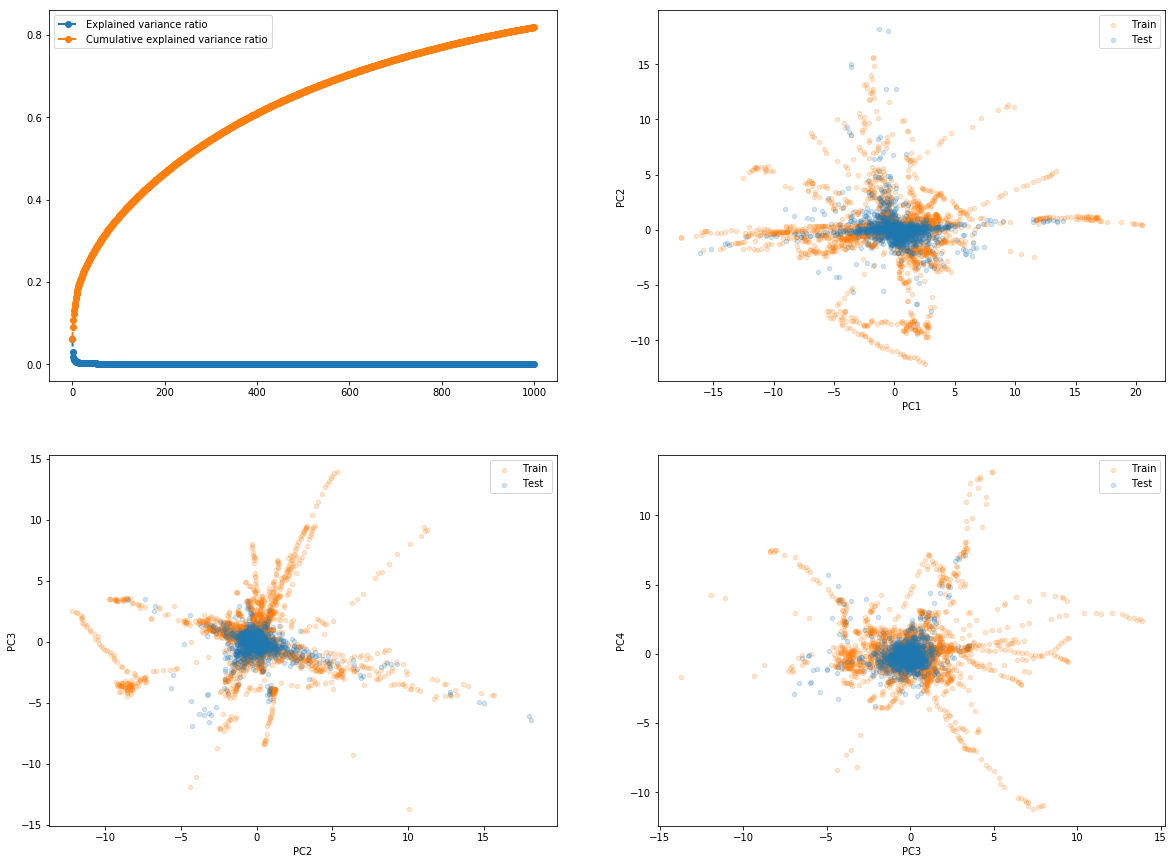

In [4]:
def test_pca(data, create_plots=True):
    """Run PCA analysis, return embedding"""
    
    # Create a PCA object, specifying how many components we wish to keep
    pca = PCA(n_components=1000)

    # Run PCA on scaled numeric dataframe, and retrieve the projected data
    pca_trafo = pca.fit_transform(data)    

    # The transformed data is in a numpy matrix. This may be inconvenient if we want to further
    # process the data, and have a more visual impression of what each column is etc. We therefore
    # put transformed/projected data into new dataframe, where we specify column names and index
    pca_df = pd.DataFrame(
        pca_trafo,
        index=total_df.index,
        columns=["PC" + str(i + 1) for i in range(pca_trafo.shape[1])]
    )

    # Only construct plots if requested
    if create_plots:
        
        # Create two plots next to each other
        _, axes = plt.subplots(2, 2, figsize=(20, 15))
        axes = list(itertools.chain.from_iterable(axes))

        # Plot the explained variance# Plot t 
        axes[0].plot(
            pca.explained_variance_ratio_, "--o", linewidth=2,
            label="Explained variance ratio"
        )

        # Plot the cumulative explained variance
        axes[0].plot(
            pca.explained_variance_ratio_.cumsum(), "--o", linewidth=2,
            label="Cumulative explained variance ratio"
        )

        # Show legend
        axes[0].legend(loc="best", frameon=True)

        # Show biplots
        for i in range(1, 4):

            # Components to be plottet
            x, y = "PC"+str(i), "PC"+str(i+1)

            # Plot biplots
            settings = {'kind': 'scatter', 'ax': axes[i], 'alpha': 0.2, 'x': x, 'y': y}
            pca_df.iloc[train_idx].plot(label='Train', c='#ff7f0e', **settings)
            pca_df.iloc[test_idx].plot(label='Test',  c='#1f77b4', **settings)    

        # Show the plot
        plt.show()
    
    return pca_df

# Run the PCA and get the embedded dimension
pca_df = test_pca(total_df)
pca_df_all = test_pca(total_df_all, create_plots=False)

I included to plot the biplots just for fun, even though only very few percent of the variation are described by those components. Looks fun, and also hints at the training data being more spread out in those components than the test data, which seems more tightly clustered around the center.

## 1.2. Running t-SNE
Having reduced the dimensionality a bit it's now possible to run the t-SNE in about 5min or so, and subsequently plot both training and test data in the embedded 2D space. In the following I do that for both the dataset cases I have prepared to see any differences.

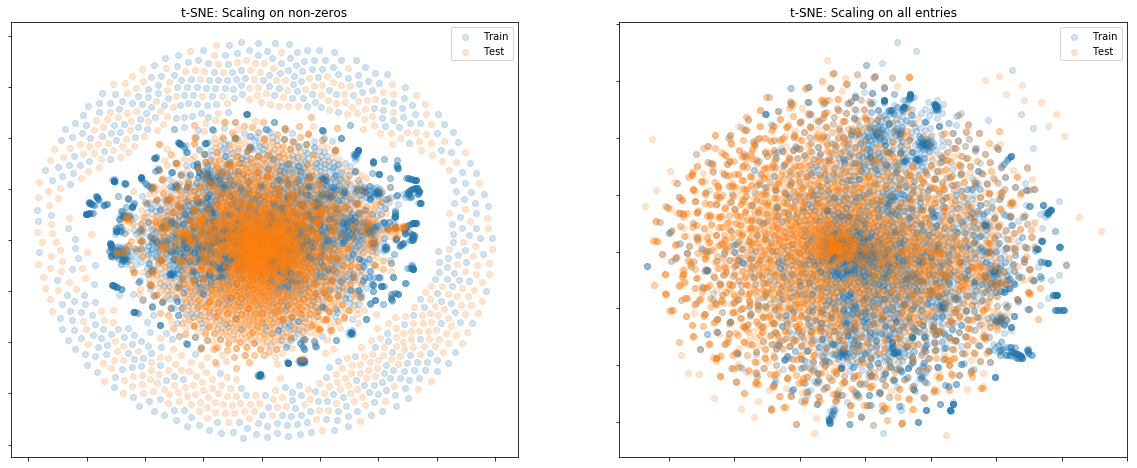

In [5]:
def test_tsne(data, ax=None, title='t-SNE'):
    """Run t-SNE and return embedding"""

    # Run t-SNE
    tsne = TSNE(n_components=2, init='pca')
    Y = tsne.fit_transform(data)

    # Create plot
    for name, idx in zip(["Train", "Test"], [train_idx, test_idx]):
        ax.scatter(Y[idx, 0], Y[idx, 1], label=name, alpha=0.2)
        ax.set_title(title)
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
    ax.legend()        
    return Y

# Run t-SNE on PCA embedding
_, axes = plt.subplots(1, 2, figsize=(20, 8))

tsne_df = test_tsne(
    pca_df, axes[0],
    title='t-SNE: Scaling on non-zeros'
)
tsne_df_unique = test_tsne(
    pca_df_all, axes[1],
    title='t-SNE: Scaling on all entries'
)

plt.axis('tight')
plt.show()  

From this is seems like if scaling is performed only on non-zero entries, then the training and test set look more similar. If scaling is performed on all entries it seems like the two datasets are more separated from each other. In a previous notebook I didn't remove duplicate columns or columns with zero standard deviation - in that case even more significant differences were observed. Of course, it's still always important to be careful with t-SNE intepretation in my experience, and it might be worth looking into in more detail; both in terms of t-SNE parameters, pre-processing, etc.

# 2. Classification of Test vs. Train
Another good check is to see how well we can classify whether a given entry belongs to test or training dataset - if it is possible to do this reasonably well, that is an indication of differences between the two dataset distributions. I'll just run a simple shuffled 10-fold cross-validation with a basic random forest model to see how well it performs this task. First let's try that classification on the case where scaling is performed on all entries:

In [29]:
def test_prediction(data):
    """Try to classify train/test samples from total dataframe"""

    # Create a target which is 1 for training rows, 0 for test rows
    y = np.zeros(len(data))
    y[train_idx] = 1

    # Perform shuffled CV predictions of train/test label
    predictions = cross_val_predict(
        ExtraTreesClassifier(n_estimators=100, n_jobs=4),
        data, y,
        cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
        method='predict_proba')
    
    return y, predictions

In [30]:
# Run classification on total raw data
y_true, pred_total_all = test_prediction(total_df_all)

In [46]:
# Show the classification report
print(classification_report(y_true, (pred_total_all[:,1]>0.5).astype(int)))

             precision    recall  f1-score   support

        0.0       0.89      0.53      0.66      4459
        1.0       0.66      0.93      0.77      4459

avg / total       0.77      0.73      0.72      8918



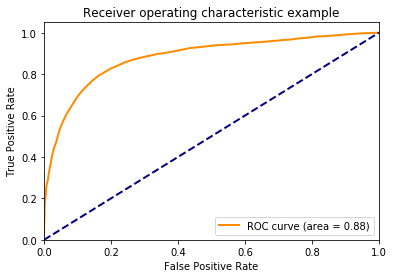

In [47]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true, pred_total_all[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

On the current notebook this gives about a 0.71 f1 score, which means we can do this prediction quite well, indicating some significant differences between the datasets. Let us try on the dataset where we only scaled non-zero values:

In [48]:
y_true, pred_total = test_prediction(total_df)

In [49]:
print(classification_report(y_true, (pred_total[:,1]>0.5).astype(int)))

             precision    recall  f1-score   support

        0.0       0.86      0.46      0.60      4459
        1.0       0.63      0.93      0.75      4459

avg / total       0.75      0.69      0.67      8918



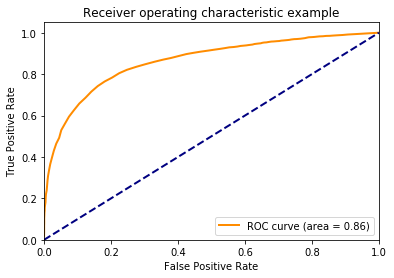

In [52]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true, pred_total[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

This reduced the f1 score a little bit down to 0.68; corresponding to what we observed in the t-SNE analysis, but still it's apparently quite easy for the model to decently well distinguish between train and test - considering the very simple classifcation model used here.

# 3. Feature-by-feature distribution similarity
Next let us try to look at the problem feature-by-feature, and perform Kolomogorov-Smirnov tests to see if the distribution in test and training set is similar. I'll use the function [scipy.stats.ks_2samp](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html#scipy.stats.ks_2samp) from scipy to run the tests. For all those features where the distributions are highly distinguishable, we may benefit from ignoring those columns, so as to avoid overfitting on training data. In the following I just identify those columns, and plot the distributions as a sanity check for some of the features

In [55]:
# Let us get the full test dataset
test_full_df = pd.read_csv('../input/test.csv')

# Find the columns where the distributions are very different
diff_data = []
for col in tqdm(total_df.columns):
    statistic, pvalue = ks_2samp(
        train_df[col].values, 
        test_full_df[col].values
    )
    if pvalue <= 0.05 and np.abs(statistic) > 0.1:
        diff_data.append({'feature': col, 'p': np.round(pvalue, 5), 'statistic': np.round(np.abs(statistic), 2)})

# Put the differences into a dataframe
diff_df = pd.DataFrame(diff_data).sort_values(by='statistic', ascending=False)

100%|██████████| 4730/4730 [00:23<00:00, 198.50it/s]


In [56]:
print(diff_df.shape)
diff_df.head()

(150, 3)


,feature,p,statistic
60,0ff32eb98,0.0,0.27
135,c5a231d81,0.0,0.25
112,adb64ff71,0.0,0.24
141,c47340d97,0.0,0.24
85,91f701ba2,0.0,0.23


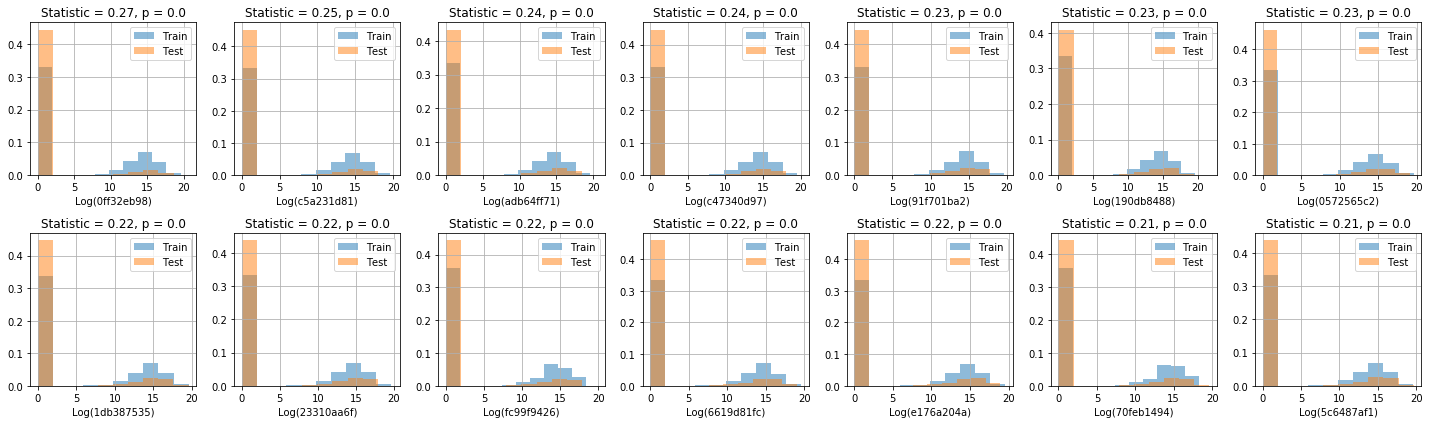

In [57]:
# Let us see the distributions of these columns to confirm they are indeed different
n_cols = 7
n_rows = 2 # int(len(diff_df) / 7) # uncomment to view all
_, axes = plt.subplots(n_rows, n_cols, figsize=(20, 3*n_rows))
axes = [x for l in axes for x in l]

# Create plots
for i, (_, row) in enumerate(diff_df.iterrows()):
    if i >= len(axes):
        break
    train_df[row.feature].apply(np.log1p).hist(ax=axes[i], alpha=0.5, label='Train', density=True)
    test_full_df[row.feature].apply(np.log1p).hist(ax=axes[i], alpha=0.5, label='Test', density=True)
    axes[i].set_title(f"Statistic = {row.statistic}, p = {row.p}")
    axes[i].set_xlabel(f'Log({row.feature})')
    axes[i].legend()

plt.tight_layout()
plt.show()

On my run it dropped about 150 features. Let's try a classification report again to see if we can distinguish test from train.

In [58]:
# Run classification on total raw data
print(f">> Dropping {len(diff_df)} features based on KS tests")
y_true, pred_aft_ks = test_prediction(total_df.drop(diff_df.feature.values, axis=1))

>> Dropping 150 features based on KS tests


In [59]:
print(classification_report(y_true, (pred_aft_ks[:,1]>0.5).astype(int)))

             precision    recall  f1-score   support

        0.0       0.83      0.36      0.50      4459
        1.0       0.59      0.92      0.72      4459

avg / total       0.71      0.64      0.61      8918



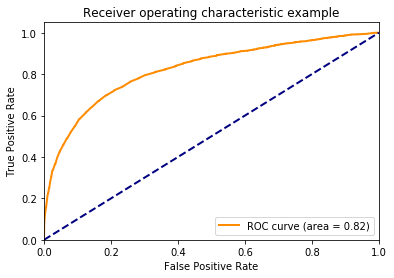

In [60]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true, pred_aft_ks[:,1])
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Here we actually see lower score, down from 68% to 62%, meaning train and test are more similar. I've not tested these things with any regressors yet, but I'd think it might be interesting to drop some if not all of these features which may enable the model to overfit on training data. I'm not sure Kolmogorov–Smirnov is neccesarily the absolute best statistical test for comparing these kinda-discrete distributions - I've tried only running it on non-zero entries, but in that case we end up removing many more features, while still allowing the model to easily distinguish between train and test based on the zeroes. Suggestions on how to approach this more thoroughly would be appreciated.

To be updated.